In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
#generate url list
def getUrl(year):
    baseUrl = "https://www.basketball-reference.com/leagues/NBA_"
    months = ["october", "november", "december", "january", "february", "march", "april", "may", "june"]
    urlList = []
    year += 1
    for month in months:
        urlList.append(baseUrl + str(year) + "_games-" + month + ".html")
    return urlList

In [3]:
def compareScore(team1, score1, team2, score2):
    if score1 > score2:
        return (team1, team2)
    return (team2, team1)

In [4]:

#download html pages from urlList and parse the data
def collectAndParse(urlList):
    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore", "winTeam", "loseTeam"])
    reg = []
    try:
        for url in urlList:
            #print "working on " + url
            result = requests.get(url).text
            soup = BeautifulSoup(result, 'html.parser').find("table", {"id" : "schedule"}).find("tbody")
            for game in soup.find_all("tr"):
                gameDetail = {}

                gameDetail["date"] = game.find("th").get_text()

                if "Playoffs" in gameDetail["date"]:
                    reg = post
                    post = pd.DataFrame(columns=["date", "away", "awayScore", "home", "homeScore", "winTeam", "loseTeam"])
                    continue

                gameDetail["away"] = game.find("td", {"data-stat" : "visitor_team_name"}).get_text()
                gameDetail["awayScore"] = int(game.find("td", {"data-stat" : "visitor_pts"}).get_text())
                gameDetail["home"] = game.find("td", {"data-stat" : "home_team_name"}).get_text()
                gameDetail["homeScore"] = int(game.find("td", {"data-stat" : "home_pts"}).get_text())
                gameDetail["winTeam"], gameDetail["loseTeam"] = compareScore(gameDetail["away"], gameDetail["awayScore"], gameDetail["home"], gameDetail["homeScore"])
                data = pd.Series(gameDetail)
                post = post.append(data, ignore_index = True)
    except:
        if reg == []: reg = post
        return (reg, post)
    return (reg, post)

In [5]:
#Reference: https://github.com/sublee/trueskill#
import math
def cdf(x, mu=0, sigma=1):
    return 0.5 * erfc(-(x - mu) / (sigma * math.sqrt(2)))


def pdf(x, mu=0, sigma=1):
    return (1 / math.sqrt(2 * math.pi) * abs(sigma) *
            math.exp(-(((x - mu) / abs(sigma)) ** 2 / 2)))

def erfc(x):
    """Complementary error function (via `http://bit.ly/zOLqbc`_)"""
    z = abs(x)
    t = 1. / (1. + z / 2.)
    r = t * math.exp(-z * z - 1.26551223 + t * (1.00002368 + t * (
        0.37409196 + t * (0.09678418 + t * (-0.18628806 + t * (
            0.27886807 + t * (-1.13520398 + t * (1.48851587 + t * (
                -0.82215223 + t * 0.17087277
            )))
        )))
    )))
    return 2. - r if x < 0 else r

In [6]:
def TrueSkill(data, TrueSkillTable = 0, eps = 0):
    import copy
    #build Skill Table if not exists
    if type(TrueSkillTable) is not pd.DataFrame:
        TrueSkillTable = {}
        TrueSkillTable["team"] = data.away.unique()
        TrueSkillTable["mu"] = 1200.0
        TrueSkillTable["sigma"] = 1200.0/3
        TrueSkillTable["win"] = 0
        TrueSkillTable["lose"] = 0
        TrueSkillTable = pd.DataFrame(TrueSkillTable, columns = ["team", "mu", "sigma", "win", "lose"])
        beta = 1200.0/3/2
    else:
        teams = data.away.unique()
        TrueSkillTable = TrueSkillTable.loc[TrueSkillTable['team'].isin(teams)]
        TrueSkillTable["win"] = 0
        TrueSkillTable["lose"] = 0
        beta = sum(TrueSkillTable.sigma) / 16.0
        
    #build record mu overtime
    overtimeTable = {}
    overtimeTable["team"] = TrueSkillTable.team
    #overtimeTable["startingMu"] = copy.deepcopy(TrueSkillTable.mu)
    dateList = data.date.unique()

    for date in dateList:
        currentData = data[data.date == date]

        for result in currentData.iterrows():
            result = result[1]
            winTeam = result.winTeam
            loseTeam = result.loseTeam
            
            winMu = float(TrueSkillTable[TrueSkillTable.team == winTeam].mu.values[0])
            winSigma = float(TrueSkillTable[TrueSkillTable.team == winTeam].sigma.values[0])
            loseMu = float(TrueSkillTable[TrueSkillTable.team == loseTeam].mu.values[0])
            loseSigma = float(TrueSkillTable[TrueSkillTable.team == loseTeam].sigma.values[0])
            c = (2.0 * beta**2 + winSigma ** 2 + loseSigma ** 2)**(.5)
            t = (winMu - loseMu)/c
            v = pdf(t - eps)/cdf(t - eps)
            w = v * (v + t - eps)
            
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'win'] += 1
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'lose'] += 1
            
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'mu'] = winMu + (winSigma ** 2) / c * v
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'mu'] = loseMu - (loseSigma ** 2) / c * v
            TrueSkillTable.loc[TrueSkillTable.team == winTeam, 'sigma'] = (winSigma ** 2 * (1 - (winSigma ** 2) / (c ** 2) * w)) **(.5)
            TrueSkillTable.loc[TrueSkillTable.team == loseTeam, 'sigma'] = (loseSigma ** 2 * (1 - (loseSigma ** 2) / (c ** 2) * w)) **(.5)
        date = pd.to_datetime(date[5:], format = '%b %d, %Y')
        overtimeTable[date] = copy.deepcopy(TrueSkillTable.mu)
    overtimeTable = pd.DataFrame(overtimeTable)
    overtimeTable = overtimeTable.set_index('team')
    overtimeTable = overtimeTable.transpose()
    overtimeTable = overtimeTable.sort_index()
    overtimeTable = overtimeTable.sort_values(by=overtimeTable.index[-1], ascending=False, axis=1)
    TrueSkillTable = TrueSkillTable.sort_values(by = 'mu', ascending = False)
    return (TrueSkillTable, overtimeTable)

In [7]:
reg, post =  collectAndParse(getUrl(2018))

ranking, timetable = TrueSkill(reg)

In [8]:
timetable

team,Toronto Raptors,Denver Nuggets,Los Angeles Clippers,Milwaukee Bucks,Los Angeles Lakers,Memphis Grizzlies,Philadelphia 76ers,Golden State Warriors,Oklahoma City Thunder,Minnesota Timberwolves,...,Washington Wizards,San Antonio Spurs,Charlotte Hornets,New York Knicks,Miami Heat,Brooklyn Nets,Cleveland Cavaliers,Phoenix Suns,Atlanta Hawks,Chicago Bulls
2018-10-16 00:00:00,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,998.149404,1401.850596,998.149404,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
2018-10-17 00:00:00,1401.850596,1401.850596,998.149404,1401.850596,1200.000000,998.149404,998.149404,1401.850596,998.149404,998.149404,...,1200.000000,1401.850596,998.149404,1401.850596,998.149404,998.149404,998.149404,1401.850596,998.149404,1200.000000
2018-10-18 00:00:00,1401.850596,1401.850596,998.149404,1401.850596,998.149404,998.149404,1201.873028,1401.850596,998.149404,998.149404,...,926.674652,1401.850596,998.149404,1401.850596,1201.873028,998.149404,998.149404,1401.850596,998.149404,926.674652
2018-10-19 00:00:00,1570.450823,1401.850596,1166.749631,1570.450823,998.149404,1166.749631,1201.873028,1570.450823,829.549177,1166.749631,...,926.674652,1401.850596,1273.313079,1126.686921,1201.873028,1273.313079,829.549177,1401.850596,829.549177,926.674652
2018-10-20 00:00:00,1607.269652,1570.450823,1166.749631,1570.450823,829.549177,1166.749631,1329.252269,1570.450823,829.549177,996.881808,...,882.140188,1233.250369,1392.704346,1014.146162,1073.687800,1130.456165,829.549177,1233.250369,829.549177,858.592082
2018-10-21 00:00:00,1607.269652,1712.128567,1308.427375,1570.450823,829.549177,1166.749631,1329.252269,1428.773079,707.325843,996.881808,...,882.140188,1233.250369,1392.704346,1014.146162,1073.687800,1130.456165,687.871433,1233.250369,971.226921,858.592082
2018-10-22 00:00:00,1698.809504,1712.128567,1308.427375,1614.933899,763.457023,1323.443051,1329.252269,1509.832283,707.325843,1206.606491,...,1217.810381,1299.342523,1316.558026,980.609506,1073.687800,1130.456165,687.871433,1129.196251,971.226921,783.763706
2018-10-23 00:00:00,1698.809504,1736.433410,1225.639641,1614.933899,763.457023,1323.443051,1240.353696,1509.832283,707.325843,1206.606491,...,1217.810381,1299.342523,1316.558026,980.609506,1073.687800,1130.456165,687.871433,1129.196251,971.226921,783.763706
2018-10-24 00:00:00,1736.203029,1736.433410,1225.639641,1677.306498,979.220186,1137.198231,1193.134925,1567.291822,707.325843,1176.680741,...,1152.698740,1135.557854,1113.309579,890.158107,1178.277969,1174.295304,641.315317,926.977685,1161.482274,1060.961521
2018-10-25 00:00:00,1736.203029,1432.893187,1225.639641,1677.306498,1245.693057,1137.198231,1193.134925,1567.291822,660.093971,1176.680741,...,1152.698740,1135.557854,1113.309579,890.158107,1178.277969,1174.295304,634.685180,926.977685,1161.482274,1060.961521


In [12]:
rankingPost, timetablePost = TrueSkill(post, TrueSkillTable= ranking)

/Users/pydu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/pydu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/pydu/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [ ]:
WC = ['Los Angeles Clippers', 'Milwaukee Bucks', 'Los Angeles Lakers', 'Memphis Grizzlies',\
     'Golden State Warriors', 'Oklahoma City Thunder', 'Minnesota Timberwolves', 'Sacramento Kings', \
     'Dallas Mavericks', 'Portland Trail Blazers', 'Utah Jazz', 'Houston Rockets', 'New Orleans Pelicans',\
     'San Antonio Spurs', 'Phoenix Suns']

EC = ['Toronto Raptors', 'Philadelphia 76ers', 'Boston Celtics', 'Detroit Pistons', 'Indiana Pacers', \
     'Orlando Magic', 'Washington Wizards', 'Charlotte Hornets', 'New York Knicks', 'Miami Heat', \
     'Brooklyn Nets', 'Cleveland Cavaliers', 'Atlanta Hawks', 'Chicago Bulls', 'Denver Nuggets']

In [26]:
timetable[WC]

team,Los Angeles Clippers,Milwaukee Bucks,Los Angeles Lakers,Memphis Grizzlies,Golden State Warriors,Oklahoma City Thunder,Minnesota Timberwolves,Sacramento Kings,Dallas Mavericks,Portland Trail Blazers,Utah Jazz,Houston Rockets,New Orleans Pelicans,San Antonio Spurs,Phoenix Suns
2018-10-16 00:00:00,1200.000000,1200.000000,1200.000000,1200.000000,1401.850596,998.149404,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
2018-10-17 00:00:00,998.149404,1401.850596,1200.000000,998.149404,1401.850596,998.149404,998.149404,998.149404,998.149404,1200.000000,1401.850596,998.149404,1401.850596,1401.850596,1401.850596
2018-10-18 00:00:00,998.149404,1401.850596,998.149404,998.149404,1401.850596,998.149404,998.149404,998.149404,998.149404,1401.850596,1401.850596,998.149404,1401.850596,1401.850596,1401.850596
2018-10-19 00:00:00,1166.749631,1570.450823,998.149404,1166.749631,1570.450823,829.549177,1166.749631,912.581050,998.149404,1401.850596,1233.250369,998.149404,1487.418950,1401.850596,1401.850596
2018-10-20 00:00:00,1166.749631,1570.450823,829.549177,1166.749631,1570.450823,829.549177,996.881808,912.581050,1221.178661,1570.450823,1233.250369,1166.749631,1487.418950,1233.250369,1233.250369
2018-10-21 00:00:00,1308.427375,1570.450823,829.549177,1166.749631,1428.773079,707.325843,996.881808,1045.798445,1221.178661,1570.450823,1233.250369,1025.071888,1487.418950,1233.250369,1233.250369
2018-10-22 00:00:00,1308.427375,1614.933899,763.457023,1323.443051,1509.832283,707.325843,1206.606491,1045.798445,1289.015085,1255.023763,1076.556949,1025.071888,1487.418950,1299.342523,1129.196251
2018-10-23 00:00:00,1225.639641,1614.933899,763.457023,1323.443051,1509.832283,707.325843,1206.606491,1019.282333,1289.015085,1255.023763,1076.556949,1025.071888,1603.251267,1299.342523,1129.196251
2018-10-24 00:00:00,1225.639641,1677.306498,979.220186,1137.198231,1567.291822,707.325843,1176.680741,1207.163745,1094.633404,1255.023763,1185.094745,915.193851,1603.251267,1135.557854,926.977685
2018-10-25 00:00:00,1225.639641,1677.306498,1245.693057,1137.198231,1567.291822,660.093971,1176.680741,1207.163745,1094.633404,1360.551560,1185.094745,915.193851,1603.251267,1135.557854,926.977685


In [27]:
timetable[EC]

team,Toronto Raptors,Philadelphia 76ers,Boston Celtics,Detroit Pistons,Indiana Pacers,Orlando Magic,Washington Wizards,Charlotte Hornets,New York Knicks,Miami Heat,Brooklyn Nets,Cleveland Cavaliers,Atlanta Hawks,Chicago Bulls,Denver Nuggets
2018-10-16 00:00:00,1200.000000,998.149404,1401.850596,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
2018-10-17 00:00:00,1401.850596,998.149404,1401.850596,1401.850596,1401.850596,1401.850596,1200.000000,998.149404,1401.850596,998.149404,998.149404,998.149404,998.149404,1200.000000,1401.850596
2018-10-18 00:00:00,1401.850596,1201.873028,1401.850596,1401.850596,1401.850596,1401.850596,926.674652,998.149404,1401.850596,1201.873028,998.149404,998.149404,998.149404,926.674652,1401.850596
2018-10-19 00:00:00,1570.450823,1201.873028,1233.250369,1401.850596,1233.250369,1126.686921,926.674652,1273.313079,1126.686921,1201.873028,1273.313079,829.549177,829.549177,926.674652,1401.850596
2018-10-20 00:00:00,1607.269652,1329.252269,1353.322742,1475.753311,1385.667758,1008.046348,882.140188,1392.704346,1014.146162,1073.687800,1130.456165,829.549177,829.549177,858.592082,1570.450823
2018-10-21 00:00:00,1607.269652,1329.252269,1353.322742,1475.753311,1385.667758,1008.046348,882.140188,1392.704346,1014.146162,1073.687800,1130.456165,687.871433,971.226921,858.592082,1712.128567
2018-10-22 00:00:00,1698.809504,1329.252269,1151.323064,1475.753311,1179.421567,1199.435492,1217.810381,1316.558026,980.609506,1073.687800,1130.456165,687.871433,971.226921,783.763706,1712.128567
2018-10-23 00:00:00,1698.809504,1240.353696,1151.323064,1599.932512,1179.421567,1199.435492,1217.810381,1316.558026,980.609506,1073.687800,1130.456165,687.871433,971.226921,783.763706,1736.433410
2018-10-24 00:00:00,1736.203029,1193.134925,1151.323064,1599.932512,1290.963078,1199.435492,1152.698740,1113.309579,890.158107,1178.277969,1174.295304,641.315317,1161.482274,1060.961521,1736.433410
2018-10-25 00:00:00,1736.203029,1193.134925,1186.421400,1608.245415,1290.963078,1115.212849,1152.698740,1113.309579,890.158107,1178.277969,1174.295304,634.685180,1161.482274,1060.961521,1432.893187


In [34]:
ranking[ranking["team"].isin(WC)]

,team,mu,sigma,win,lose
28,Los Angeles Clippers,1379.898404,89.607792,16,8
2,Milwaukee Bucks,1377.336966,92.041645,16,7
14,Los Angeles Lakers,1354.774141,90.334860,15,9
5,Memphis Grizzlies,1350.037701,87.931823,14,9
20,Golden State Warriors,1325.553723,90.831090,17,9
1,Oklahoma City Thunder,1301.658867,94.028610,16,7
11,Minnesota Timberwolves,1288.787950,87.582468,13,12
17,Sacramento Kings,1285.264077,95.298367,12,11
9,Dallas Mavericks,1268.148724,88.023751,12,11
29,Portland Trail Blazers,1263.287913,87.123108,13,11


In [35]:
ranking[ranking["team"].isin(EC)]

,team,mu,sigma,win,lose
26,Toronto Raptors,1489.031152,100.571651,21,5
6,Denver Nuggets,1424.443357,90.212647,17,7
0,Philadelphia 76ers,1329.323500,87.314895,17,9
19,Boston Celtics,1258.575826,90.097254,13,10
21,Detroit Pistons,1237.506369,93.723123,13,9
16,Indiana Pacers,1215.409259,88.746563,14,10
24,Orlando Magic,1188.019446,87.652440,12,13
27,Washington Wizards,1148.858647,86.222476,11,14
18,Charlotte Hornets,1108.114318,86.116312,11,13
15,New York Knicks,1065.379094,90.395882,8,17


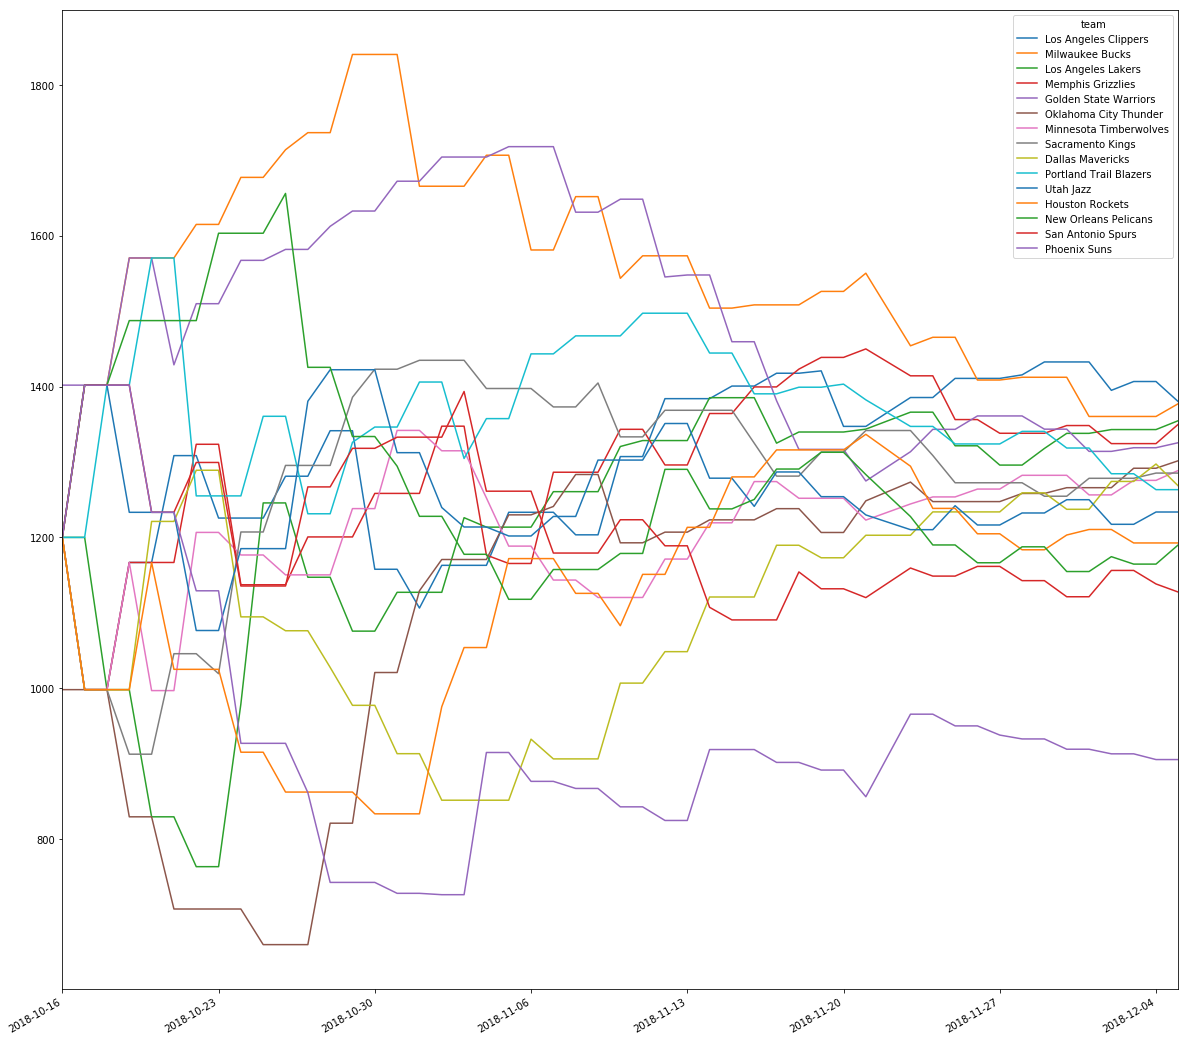

In [43]:
timetable[WC].plot(figsize = (20,20))
plt.show()

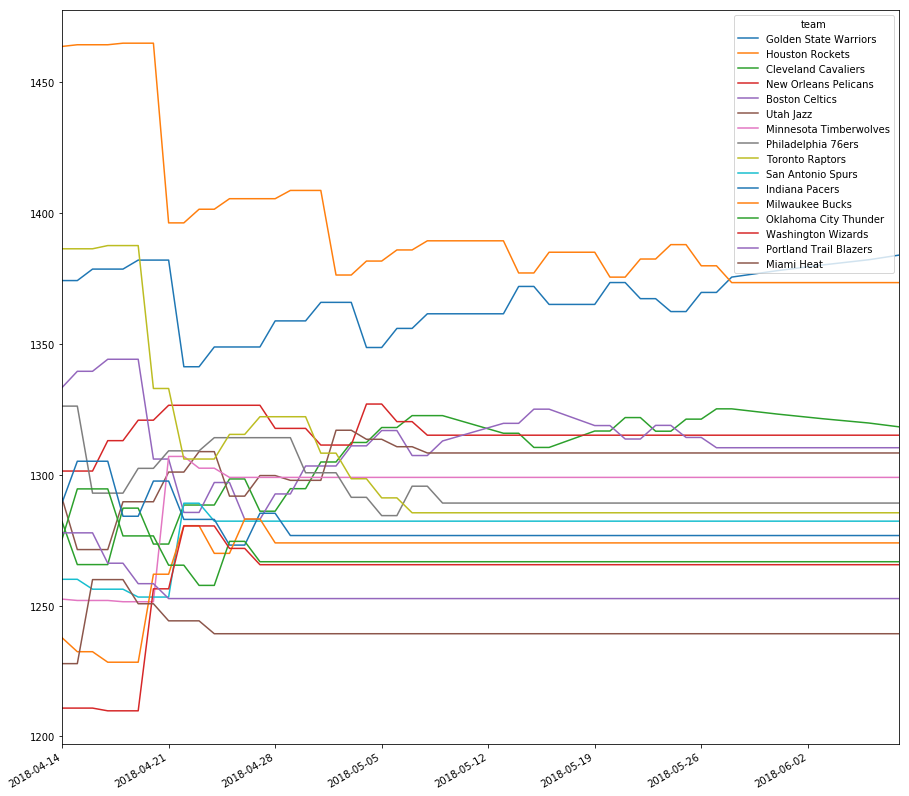

In [13]:
timetablePost[list(timetablePost.columns[0:16])].plot(figsize = (15,15))
plt.show()

In [14]:
rankingPost

,team,mu,sigma,win,lose
19,Golden State Warriors,1383.988149,19.156230,16,5
1,Houston Rockets,1373.474146,21.550482,11,6
17,Cleveland Cavaliers,1318.344322,17.480858,12,10
6,New Orleans Pelicans,1315.153065,26.165185,5,4
0,Boston Celtics,1310.364332,18.577908,11,8
18,Utah Jazz,1308.360093,24.556169,5,6
9,Minnesota Timberwolves,1299.027864,35.302065,1,4
11,Philadelphia 76ers,1289.217796,24.672940,5,5
29,Toronto Raptors,1285.501933,25.609307,4,6
22,San Antonio Spurs,1282.301302,33.916519,1,4


In [15]:
ranking

,team,mu,sigma,win,lose
1,Houston Rockets,1463.742644,48.037023,65,17
29,Toronto Raptors,1385.025459,45.507988,59,23
19,Golden State Warriors,1368.402731,47.338683,58,24
0,Boston Celtics,1333.390212,46.042068,55,27
11,Philadelphia 76ers,1319.953550,43.403335,52,30
8,Portland Trail Blazers,1297.227558,42.985951,49,33
18,Utah Jazz,1290.996433,43.059870,48,34
25,Indiana Pacers,1289.361191,43.086520,48,34
17,Cleveland Cavaliers,1282.051736,43.772729,50,32
6,New Orleans Pelicans,1282.039767,43.005429,48,34


In [10]:
collectAndParse(getUrl(2017))

(                  date                    away awayScore  \
 0    Tue, Oct 17, 2017          Boston Celtics        99   
 1    Tue, Oct 17, 2017         Houston Rockets       122   
 2    Wed, Oct 18, 2017         Milwaukee Bucks       108   
 3    Wed, Oct 18, 2017           Atlanta Hawks       117   
 4    Wed, Oct 18, 2017       Charlotte Hornets        90   
 5    Wed, Oct 18, 2017           Brooklyn Nets       131   
 6    Wed, Oct 18, 2017    New Orleans Pelicans        91   
 7    Wed, Oct 18, 2017              Miami Heat       109   
 8    Wed, Oct 18, 2017  Portland Trail Blazers       124   
 9    Wed, Oct 18, 2017         Houston Rockets       105   
 10   Wed, Oct 18, 2017  Minnesota Timberwolves        99   
 11   Wed, Oct 18, 2017          Denver Nuggets        96   
 12   Wed, Oct 18, 2017      Philadelphia 76ers       115   
 13   Thu, Oct 19, 2017    Los Angeles Clippers       108   
 14   Thu, Oct 19, 2017         New York Knicks        84   
 15   Thu, Oct 19, 2017 